# Tutorial Quantum Gates

This notebook aims to give a clear and quick tutorial to use and exploit this library to simulate the noise inside quantum device for the release 2.1.0.

We assume you follow the procedure to install the library. You can find the complete documentation [here](https://quantum-gates.readthedocs.io/en/latest/index.html)


### Setup the simulation for linear topology

First of all import the necessary packages to run a simulation. Also import your IBM TOKEN if you want to simulate the behaviour of a real device, otherwise you can use the Fake device of IBM without a TOKEN.

In [1]:
# Standard libraries
import numpy as np
import json

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKyiv

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import fix_counts
IBM_TOKEN = "f7087a0bf2fa17233e9e7af3ec451d8c2d5cbac24168f19b0f142177ab8d82aafc759c238db27c69449397759f1a7c7e80e22fa83281ba8abfcf92b7eb29414b"

Then create a quantum circuit with Qiskit

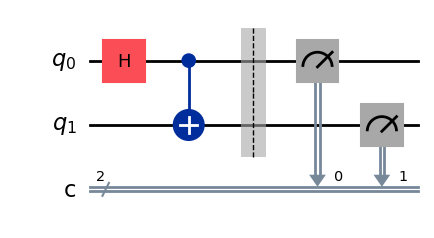

In [2]:
n_qubit = 2
n_classic_bit = 2

circ = QuantumCircuit(n_qubit,n_classic_bit)
circ.h(0)
circ.cx(0,1)
circ.barrier(range(n_qubit))
circ.measure(range(n_qubit),range(n_classic_bit))
circ.draw('mpl')

We can load the configuration from a JSON file or directly from the code, as demonstrated in the quickstart section of the README.md. Here, we define this information in a slightly different but equivalent way to what's done in the quickstart.

You can choose to use qiskit functions, otherwise you can use our function ```setup_backend``` to setup the backend as in the quick start

In [3]:
# directly with qiskit import a real device
provider = QiskitRuntimeService(channel= 'ibm_quantum', token=IBM_TOKEN)
provider.backends() 
backend_real = provider.backend('ibm_kyiv')

# fake backend without the use of the IBM_TOKEN
backend_fake = FakeKyiv()

After loading the backend we have to define the information for the simulation

In [4]:
linear_qubit_layout = [0,1] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake)
device_param_lookup = device_param.__dict__()

Then transpile the Qiskit circuit

In [5]:
# transpilation of the circuit
t_circ = transpile(
    circ,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

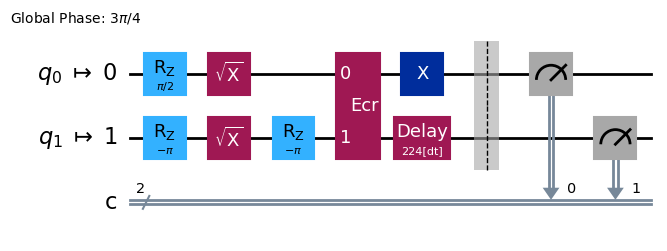

In [6]:
t_circ.draw('mpl', idle_wires= False)

Now define the simulator through the ```MrAndersonSimulator``` class and perform the simulation

In [7]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= True)

In [8]:
probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit

Our CPU count is 8
Use 80% of the cores, so 6 processes.
As we perform 100 shots, we use a chunksize of 17.


You can switch form Big-Endian order to Little-Endian order of the output to match Qiskit standard through the function ```fix_counts``` and plot the result

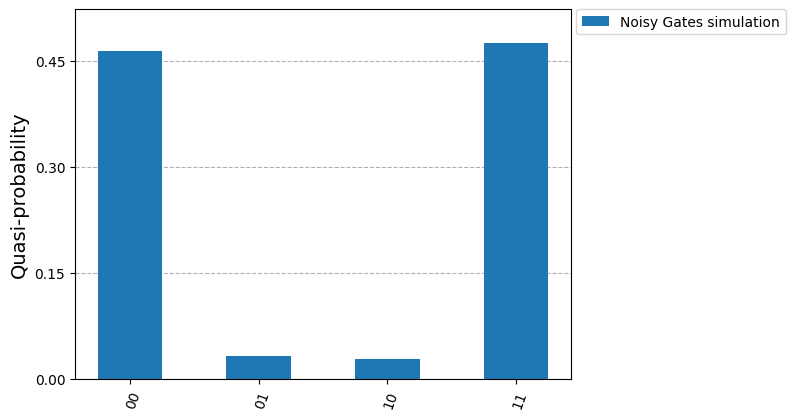

In [9]:
measured_qubit = n_classic_bit
counts_ng = fix_counts(probs, n_classic_bit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

### Non linear topology

Now we implement the same experiment but considering non linear topology. 
You can find documentation on the IBM processor types [here](https://docs.quantum.ibm.com/guides/processor-types) to see the hardware topologies. 

We are using the `ibm_kyiv` device which use a Eagle r3 processor.

First of all define a new qubit layout and consequentially import again the device parameter.

**Note:** If you are using a non linear topology you must import the information of all qubits up to the one with the max index used, otherwise the program doesn't work

In [10]:
non_linear_qubit_layout = [0,14] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(list(np.arange(max(non_linear_qubit_layout)+1)))
device_param.load_from_backend(backend_fake)
device_param_lookup = device_param.__dict__()

The following is similat as before 

In [11]:
# transpilation of the circuit
t_circ_2 = transpile(
    circ,
    backend_fake,
    initial_layout=non_linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

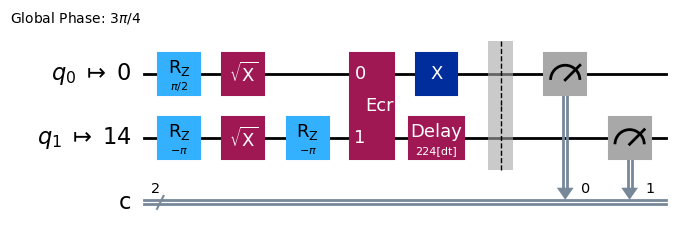

In [12]:
t_circ_2.draw('mpl', idle_wires= False)

Define a new simulator object using the `BinaryCircuit` class that allows to run experiment with non-linear topologies


In [13]:
sim_2 = MrAndersonSimulator(gates=standard_gates, CircuitClass=BinaryCircuit, parallel= True)

and run the simulation as before taking care to modify the input parameters

In [14]:
probs_2 = sim_2.run(
    t_qiskit_circ=t_circ_2, 
    qubits_layout=non_linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit)


Our CPU count is 8
Use 80% of the cores, so 6 processes.
As we perform 100 shots, we use a chunksize of 17.


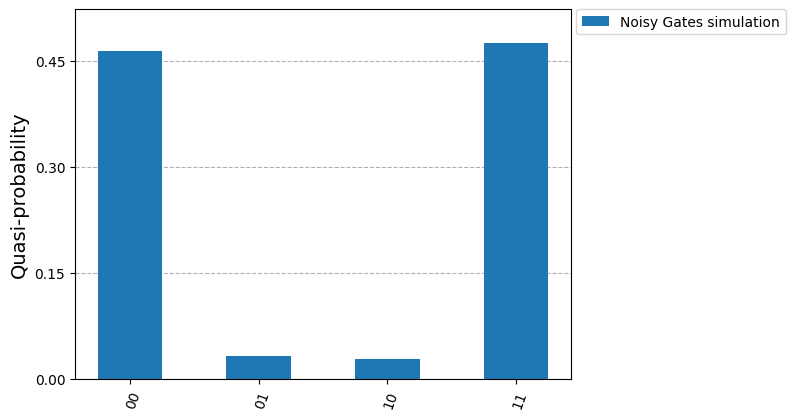

In [15]:
measured_qubit = n_classic_bit
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

### Comparison with Qiskit

We can make a comparison with Qiskit to see the differences in the results

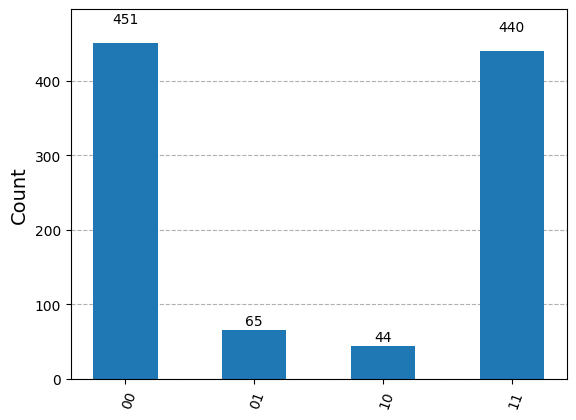

In [16]:
# Simulation with Qiskit
t_circ = transpile(
    circ,
    backend_fake,
    initial_layout=non_linear_qubit_layout,
    seed_transpiler=42,
)

# Run the transpiled circuit using the fake backend
job = backend_fake.run(t_circ, shots=1000)
counts_qiskit = job.result().get_counts()
plot_histogram(counts_qiskit)

### Measure less qubits respect the ones used

The simulator allows you also to measure less qubits that the ones you use in the computation just re-defining the measurament in the Qiskit circuit. You can do it  independently from the topology of the layout.

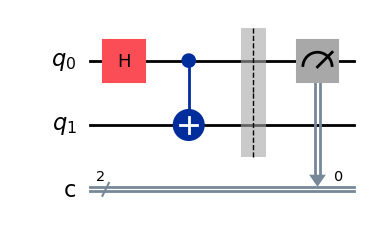

In [17]:
n_qubit = 2

circ = QuantumCircuit(n_qubit,n_classic_bit)
circ.h(0)
circ.cx(0,1)
circ.barrier(range(n_qubit))
circ.measure(qubit = 0, cbit = 0)
circ.draw('mpl')

Repeat again all the instruction to run the simulation 

In [18]:
linear_qubit_layout = [0,1] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake)
device_param_lookup = device_param.__dict__()

In [19]:
# transpilation of the circuit
t_circ = transpile(
    circ,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

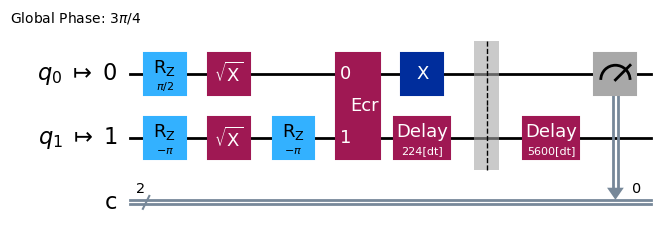

In [20]:
t_circ.draw('mpl', idle_wires= False)

In [21]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= True)

In [22]:
probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit

Our CPU count is 8
Use 80% of the cores, so 6 processes.
As we perform 100 shots, we use a chunksize of 17.


Here take care to modify the number of measured qubit for the switching from Big to Little Endian convetion

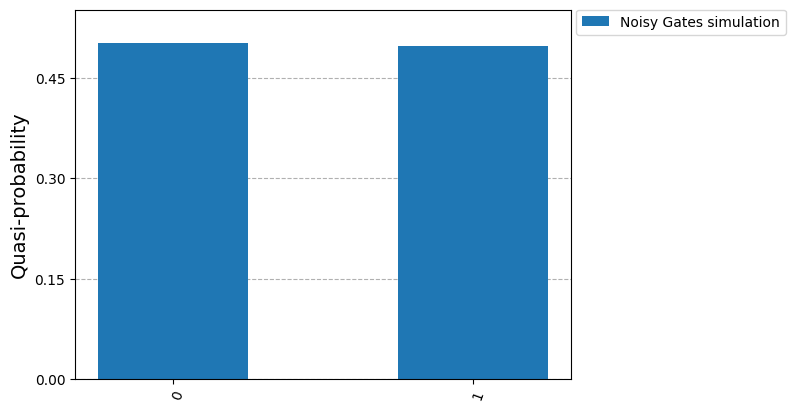

In [23]:
measured_qubit = 1
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

As expected, we obtain the result when measuring only one of the qubits.

Now that all the functionalities are displayed you can use and modify this notebook to run more complex simulation using the simulator. 

Enjoy it!